In [1]:
from DSGRN import *

import sys
sys.path.insert(0,'../scr')

from MLR_diagonstic_plots import *
from network_prelim import *
from network_topology_fun import *

In [2]:
import json
# network-of-interest numbers
# 18176: 'FullConn',  46402: 'StrongEdges'

with open('true_monostable_results_w_all_possible_networks.json') as f:
    all_pos = json.load(f)

In [3]:
results = {}
no_diag = [19597, 21636, 27722, 27822, 28692, 29385, 36374, 42122, 3138, 4554, 26176, 26304] # Become dissonnected after adding diagonal requirment
need_cut = 0
cant_cut = 0
no_path = 0
verd = 0
Reinitz = 0 
non_baseline = 0
baseline = 0
features = 0
Done = 0
for r in all_pos:
    if all_pos[r]['Feature'] == True:
        features += 1
    if all_pos[r]['Done'] == True:
        Done += 1
        if int(r) in no_diag:
            continue
        if all_pos[r]['results']['WCut'] != 'issue':
            if int(r) in [18176, 46402]: # 18176: 'FullConn',  46402: 'StrongEdges'
                results[int(r)] = all_pos[r] 
            if all_pos[r]['Baseline'] == True:
                results[int(r)] = all_pos[r] #currently only including bl and nbl into results!
                baseline += 1
            if all_pos[r]['Non Baseline'] == True:
                results[int(r)] = all_pos[r]
                non_baseline += 1
            if all_pos[r]['Strict Verd'] == True:
                verd += 1
            if all_pos[r]['Reinitz'] == True:
                Reinitz += 1
        if all_pos[r]['results']['WCut'] == 'issue':
            cant_cut +=1
    elif 'results' in all_pos[r]:
        if all_pos[r]['results']['path exists'] == False:
            print(r)
            no_path +=1
        else:
            need_cut +=1
print('Done: ', Done, len(results), '\nBaseline: ', baseline, '\nNon Baseline: ', non_baseline, '\nNo Path: ', no_path, '\nNeed Cut Redone: ', need_cut, 
      '\nCan\'t Cut: ', cant_cut, '\nNo Diag Paths: ', len(no_diag),  '\nTotal: ', len(results)+need_cut, '\nVerd Networks: ', verd , '\nReinitz Networks:', Reinitz ,'\nAll Networks: ', 
      len(all_pos) ,'\nAll Feautures: ', features)

21283
48315
Done:  1091 916 
Baseline:  728 
Non Baseline:  193 
No Path:  2 
Need Cut Redone:  0 
Can't Cut:  26 
No Diag Paths:  12 
Total:  916 
Verd Networks:  71 
Reinitz Networks: 40 
All Networks:  58368 
All Feautures:  2122


In [4]:
# Get Path Graph Size in Chemical Gradient Graph
for n in results:
    results[n]['results']['graph ratio'] = (results[n]['results']['diagP nodes in G'] + results[n]['results']['diagP edges in G'])/(results[n]['results']['G size'] + results[n]['results']['G edges'])

In [5]:
# Normalize Results
score_dict = {'WCut':1, 'graph ratio':1}
m_score_dict = {'leak + skip':1}

ma = max([results[i]['results']['markov_results']['leak + skip'] for i in results])
mi = min([results[i]['results']['markov_results']['leak + skip'] for i in results])
m_score_dict['leak + skip'] = (ma,mi)

for key in score_dict:
    ma = max([results[r]['results'][key] for r in results])
    mi = min([results[r]['results'][key] for r in results])
    score_dict[key] = (ma,mi)

keys = ['nWCut', 'nGraph', 'nls']
for r in results:
    results[r]['nWCut'] = (results[r]['results']['WCut']-score_dict['WCut'][1])/(score_dict['WCut'][0]-score_dict['WCut'][1])
    results[r]['nGraph'] = (results[r]['results']['graph ratio']-score_dict['graph ratio'][1])/(score_dict['graph ratio'][0]-score_dict['graph ratio'][1])
    results[r]['nls'] = 1-((results[r]['results']['markov_results']['leak + skip']-m_score_dict['leak + skip'][1])/(m_score_dict['leak + skip'][0] - m_score_dict['leak + skip'][1]) )

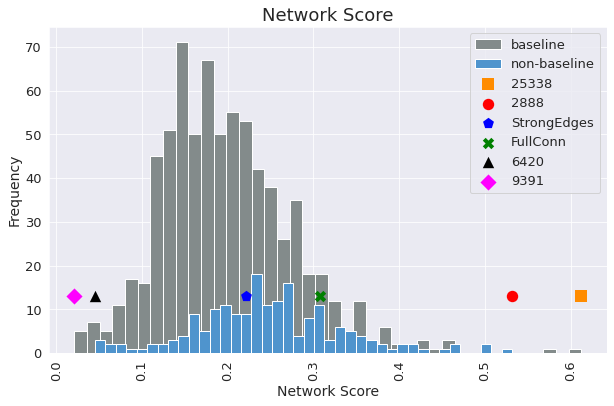

In [6]:
# Plot Histogram of robustness score as well as marking score of different networks of interest

import matplotlib.pyplot as plt
import seaborn as sns

# 18176: 'FullConn',  46402: 'StrongEdges'

interest = [25338,2888,46402,18176,6420,9391]
name = [25338,2888,'StrongEdges', 'FullConn',6420,9391]
interest_color = {}
interest_marker = {}
interest_name = {}
count = 0
pallet = ['darkorange', 'red', 'blue', 'green', 'black', 'fuchsia', 'darkorchid', 'yellowgreen', 'pink' ]
marker = ['s','o', 'p', 'X',  '^', 'D', 'P', 'v', 'o' ]
for i in interest:
    interest_name[i] = name[count]
    interest_color[i] = pallet[count]
    interest_marker[i] = marker[count]
    count += 1

sns.color_palette('deep')
plt.rcParams.update({'font.size': 18})
sns.set_style('darkgrid') # darkgrid, whitegrid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

x = []
x1 = []
c = {}
m = 40
n = 3

for r in results:
    score = (results[r]['nWCut'] + results[r]['nGraph'] + results[r]['nls'])/n
    if results[r]['Baseline'] == True:
        x.append(score)  
    elif results[r]['Feature'] == True:
        x1.append(score)
    if r in interest:
        c[r] = score
    results[r]['score'] = score

plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 18})
bins = 40
plt.xticks(rotation='vertical')
plt.ticklabel_format(style='plain')
plt.title('Network Score')
plt.hist(x, bins,color='#838B8B', label = 'baseline')
plt.hist(x1, bins, color='#4F94CD', label='non-baseline')

for i in interest:
    plt.scatter(c[i], 13, color=interest_color[i], label=interest_name[i], marker=interest_marker[i], s=130,  linewidth=0 )
plt.xlabel('Network Score')
plt.ylabel('Frequency')
plt.legend()    
plt.show()

In [7]:
# Code for Appendix F Table difference in means model
import numpy as np
import scipy.stats
# 18176: 'FullConn',  46402: 'StrongEdges'
get_info_for = ['nWCut', 'nGraph', 'nls', 'score']
print('mean  std dev  CI')
for key in get_info_for:
    data0 = [results[r][key] for r in results if results[r]['Baseline'] == True]
    data1 = [results[r][key] for r in results if results[r]['Non Baseline'] == True]
    data = np.array(data0)
    ci_95 = scipy.stats.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=scipy.stats.sem(data)) 
    data = np.array(data1)
    ci_95_nbl = scipy.stats.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=scipy.stats.sem(data))
    print(np.mean(data0), np.std(data0), list(ci_95), np.mean(data1), np.std(data1), list(ci_95_nbl), results[18176][key], results[46402][key])


mean  std dev  CI
0.13422620345683603 0.1061002922355115 [0.12650080135069347, 0.1419516055629786] 0.13856351510850987 0.12022835242444968 [0.12144955550048114, 0.1556774747165386] 0.18394112462243387 0.22191468160581054
0.3522530148202632 0.16197308289311185 [0.34045938853181423, 0.3640466411087122] 0.4492902834964662 0.1781599430634346 [0.4239300252223433, 0.47465054177058913] 0.38113837474247125 0.3865421698048552
0.10940267866165815 0.10699857891342535 [0.10161187027201476, 0.11719348705130153] 0.15507927958138243 0.11552759477737126 [0.13863445146253206, 0.1715241077002328] 0.35662944295422583 0.05644144573931098
0.19862729897958584 0.07757169396059535 [0.19297912859971525, 0.20427546935945642] 0.24764435939545282 0.08696875940944208 [0.23526475170991257, 0.26002396708099307] 0.307236314106377 0.2216327657166589


/home/elizabeth/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1765: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  facecolor=colors, edgecolor=colors)


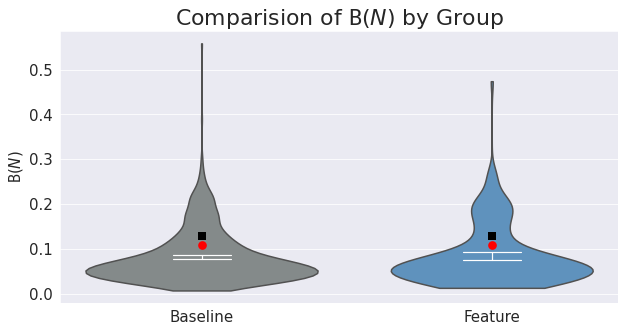

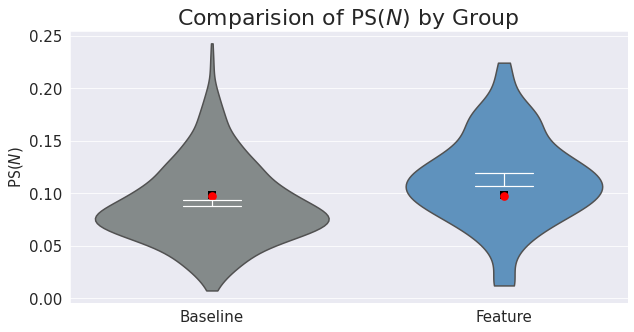

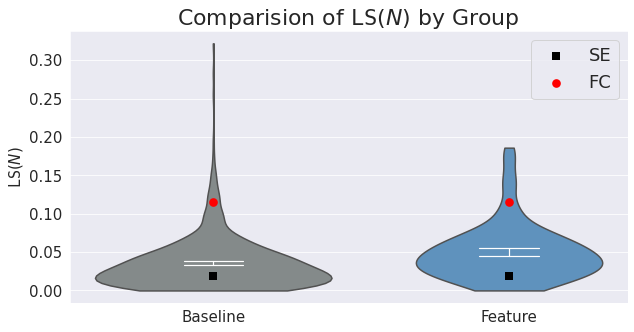

In [8]:
# Plot Measure results for each network before normalizaition
import seaborn as sns
from numpy import mean

score_dict = {'WCut':1, 'graph ratio':1}
m_score_dict = {'leak + skip':1}

ma = max([results[i]['results']['markov_results']['leak + skip'] for i in results])
mi = min([results[i]['results']['markov_results']['leak + skip'] for i in results])
m_score_dict['leak + skip'] = (ma,mi)

for key in score_dict:
    ma = max([results[r]['results'][key] for r in results])
    mi = min([results[r]['results'][key] for r in results])
    score_dict[key] = (ma,mi)

score_dict, m_score_dict

get_info_for = ['WCut', 'graph ratio', 'leak + skip']
key_lab = {'WCut':r'$\mathtt{B}(N)$', 'graph ratio':r'$\mathtt{PS}(N)$', 'leak + skip':r'$\mathtt{LS}(N)$'}
for key in get_info_for:
    if key != 'leak + skip':
        data0 = [results[r]['results'][key] for r in results if results[r]['Baseline'] == True]
        data1 = [results[r]['results'][key] for r in results if results[r]['Non Baseline'] == True]
    else:
        data0 = [1-results[r]['results']['markov_results'][key] for r in results if results[r]['Baseline'] == True]
        data1 = [1-results[r]['results']['markov_results'][key] for r in results if results[r]['Non Baseline'] == True]
    data = [np.array(data0), np.array(data1)]
    plt.figure(figsize =(10, 5))
    ax = sns.violinplot(data=data, inner=None, join=False, cut=0, palette=['#838B8B','#4F94CD'], estimator=mean)
    sns.pointplot(data=data, join=False, palette=['w'], ax=ax, errorbar=('ci', 95), markers='', capsize=.2, estimator=mean, errwidth=1.2)
    plt.xticks(np.arange(2),["Baseline", "Feature"])
    plt.title(f'Comparision of {key_lab[key]} by Group', fontsize=22)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_label_text(f'{key_lab[key]}', fontsize=15)
    a=75
    if key != 'leak + skip':
        plt.scatter(0, results[46402]['results'][key], color='k', label='SE', marker='s', s=a,  linewidth=0 )
        plt.scatter(0, results[18176]['results'][key], color='red', label='FC', marker='o', s=a,  linewidth=0 )
        plt.scatter(1, results[46402]['results'][key], color='k', marker='s', s=a,  linewidth=0 )
        plt.scatter(1, results[18176]['results'][key], color='red', marker='o', s=a,  linewidth=0 )
    else:
        plt.scatter(0, 1-results[46402]['results']['markov_results'][key], color='k', label='SE', marker='s', s=a,  linewidth=0 )
        plt.scatter(0, 1-results[18176]['results']['markov_results'][key], color='red', label='FC', marker='o', s=a,  linewidth=0 )
        plt.scatter(1, 1-results[46402]['results']['markov_results'][key], color='k', marker='s', s=a,  linewidth=0 )
        plt.scatter(1, 1-results[18176]['results']['markov_results'][key], color='red', marker='o', s=a,  linewidth=0 )

plt.legend(fontsize = 18)

    

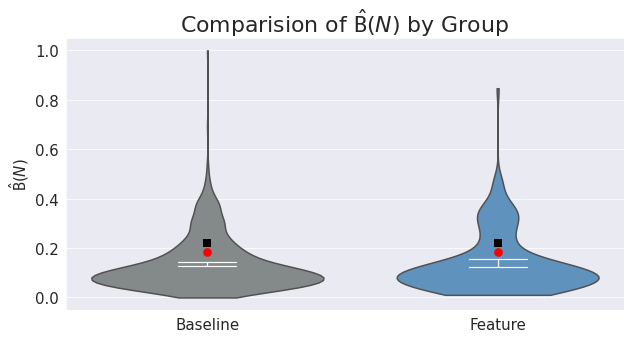

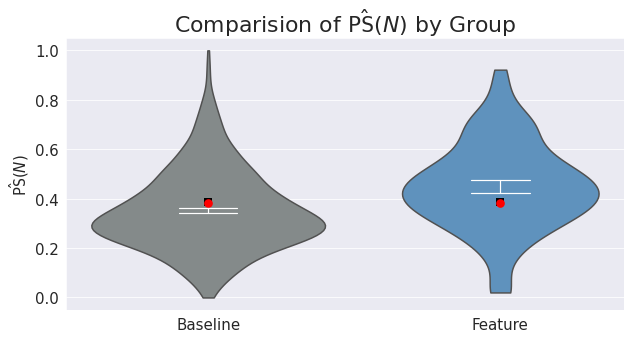

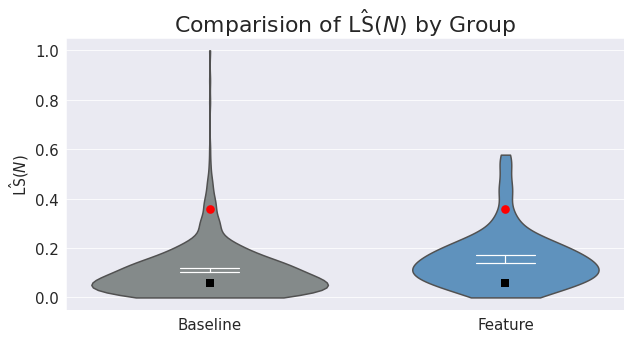

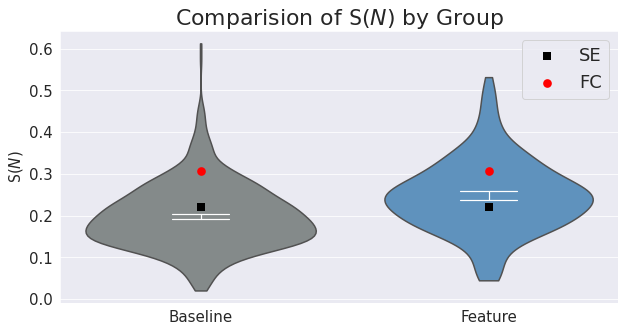

In [9]:
# Plot Measure results for each network before normalizaition
import seaborn as sns
from numpy import mean

get_info_for = ['nWCut', 'nGraph', 'nls', 'score']
key_lab = {'nWCut':r'$\hat{\mathtt{B}}(N)$', 'nGraph':r'$\hat{\mathtt{PS}}(N)$', 'nls':r'$\hat{\mathtt{LS}}(N)$', 'score':r'$\mathtt{S}(N)$'}
for key in get_info_for:
    data0 = [results[r][key] for r in results if results[r]['Baseline'] == True]
    data1 = [results[r][key] for r in results if results[r]['Non Baseline'] == True]
    data = [np.array(data0), np.array(data1)]
    plt.figure(figsize =(10, 5))
    ax = sns.violinplot(data=data, inner=None, join=False, cut=0, palette=['#838B8B','#4F94CD'], estimator=mean)
    sns.pointplot(data=data, join=False, palette=['w'], ax=ax, errorbar=('ci', 95), markers='', capsize=.2, estimator=mean, errwidth=1.2)
    plt.xticks(np.arange(2),["Baseline", "Feature"])
    plt.title(f'Comparision of {key_lab[key]} by Group', fontsize=22)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_label_text(f'{key_lab[key]}', fontsize=15)
    a=75
    plt.scatter(0, results[46402][key], color='k', label='SE', marker='s', s=a,  linewidth=0 )
    plt.scatter(0, results[18176][key], color='red', label='FC', marker='o', s=a,  linewidth=0 )
    plt.scatter(1, results[46402][key], color='k', marker='s', s=a,  linewidth=0 )
    plt.scatter(1, results[18176][key], color='red', marker='o', s=a,  linewidth=0 )

plt.legend(fontsize = 18)

    

### CSV file construction for data analytics

In [10]:
fields = ['Network', 'score', 'WCut', 'nWCut', 'graph ratio', 'nGraph', 'leak + skip', 'nls', 'Baseline', 'RE', 'PFL', 'NFL', 'ACDC1', 'ACDC2', 'ACDC3', 'Strict Verd', 'Reinitz', 'Ultra Strong']

rows = []
for r in results:
    row = [r]
    for key in fields[1:]:
        try:
            row.append(results[r][key])
        except:
            try:
                row.append(results[r]['results'][key])
            except:
                row.append(results[r]['results']['markov_results'][key])

    rows.append(row)
len(rows)

916

In [11]:
#import csv 

#filename = "network_robustness_data_20230512.csv"
    
#with open(filename, 'w') as csvfile: 
#    csvwriter = csv.writer(csvfile) 
#    csvwriter.writerow(fields) 
#    csvwriter.writerows(rows)

### Analyzing Results

In [12]:
# Order networks of interest by score
interest_order = []
for i in interest:
    for r in results:
        if i == r:
            interest_order.append((i, results[r]['score']))
interest_order = sorted(interest_order, key=lambda d: d[1], reverse=True)
interest_order

[(25338, 0.6125284141230897),
 (2888, 0.5316670136938927),
 (18176, 0.307236314106377),
 (46402, 0.2216327657166589),
 (6420, 0.04525564068291271),
 (9391, 0.020965413638698912)]

In [13]:
# What networks in Features group have highest and lowers scores?
scr = [results[r]['score'] for r in results if results[r]['Feature'] == True]
m = max(scr)
w = min(scr)
for r in results:
    if results[r]['score'] == m:
        print(f'Network {r} has the highest score')
    if results[r]['score'] == w:
        print(f'Network {r} has the lowest score')

Network 2888 has the highest score
Network 6420 has the lowest score


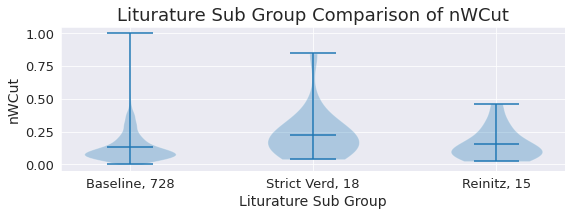

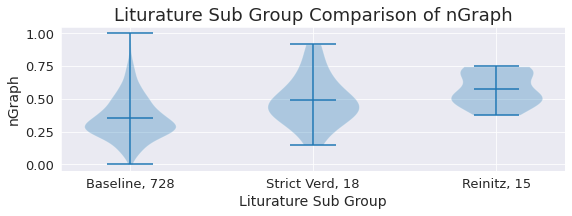

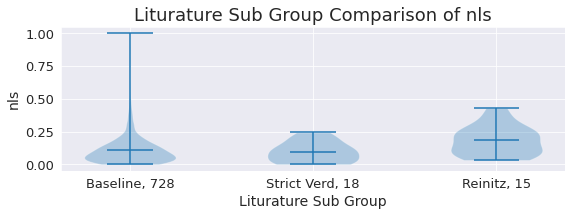

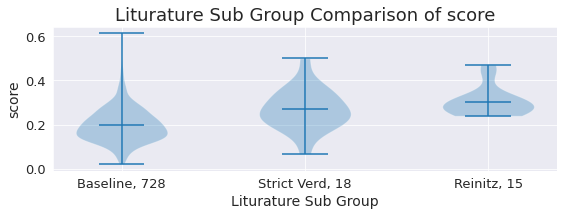

In [14]:
get_info_for = ['nWCut', 'nGraph', 'nls', 'score']

for key in get_info_for:
    data0 = [results[r][key] for r in results if results[r]['Baseline'] == True]
    data1 = [results[r][key] for r in results if results[r]['Strict Verd'] == True]
    data2 = [results[r][key] for r in results if results[r]['Reinitz'] == True]

    fig = plt.figure(figsize =(7, 2))
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.violinplot([data0, data1, data2], showmeans=True)
    plt.xticks([1, 2, 3], ['Baseline, ' + str(len(data0)), 'Strict Verd, ' + str(len(data1)), 'Reinitz, ' + str(len(data2))])
    ax.set_title('Liturature Sub Group Comparison of ' + key)
    ax.set_xlabel('Liturature Sub Group')
    ax.set_ylabel(key)
    # show plot
    plt.show()

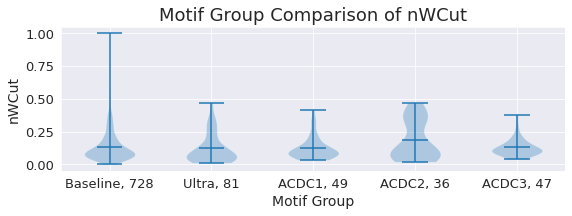

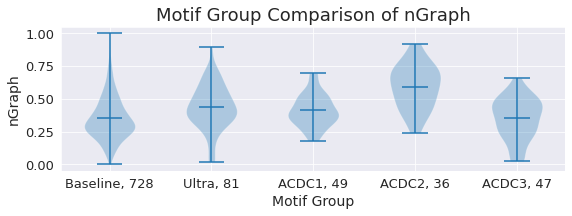

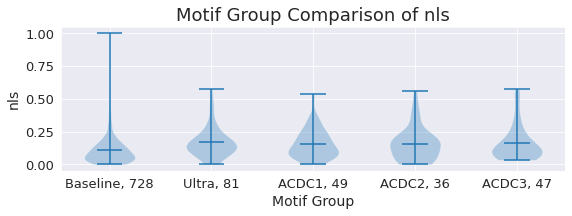

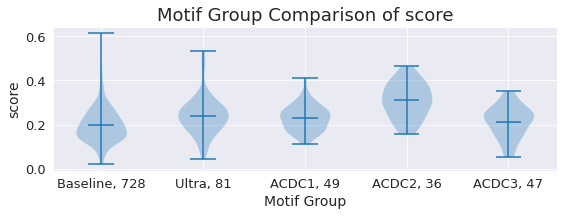

In [15]:
get_info_for = ['nWCut', 'nGraph', 'nls', 'score']
for key in get_info_for:
    data0 = [results[r][key] for r in results if results[r]['Baseline'] == True]
    data1 = [results[r][key] for r in results if results[r]['Ultra Strong'] == True]
    data2 = [results[r][key] for r in results if results[r]['ACDC1'] == True]
    data3 = [results[r][key] for r in results if results[r]['ACDC2'] == True]
    data4 = [results[r][key] for r in results if results[r]['ACDC3'] == True]

    fig = plt.figure(figsize =(7, 2))
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.violinplot([data0, data1, data2, data3, data4], showmeans=True)
    plt.xticks([1, 2, 3, 4, 5], ['Baseline, ' + str(len(data0)), 'Ultra, ' + str(len(data1)), 'ACDC1, ' + str(len(data2)), 'ACDC2, ' + str(len(data3)), 'ACDC3, ' + str(len(data4))])
    ax.set_title('Motif Group Comparison of ' + key)
    ax.set_xlabel('Motif Group')
    ax.set_ylabel(key)

    plt.show()

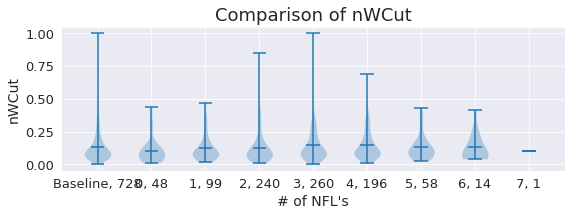

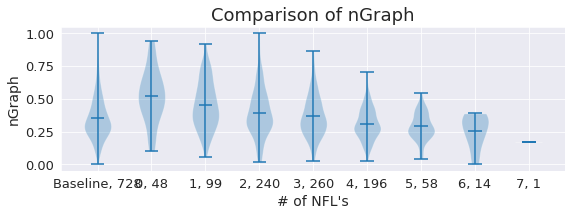

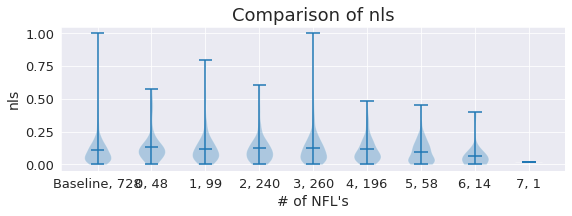

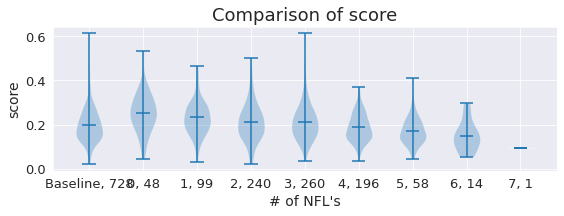

In [16]:
get_info_for = ['nWCut', 'nGraph', 'nls', 'score']

for key in get_info_for:
    data = []
    data0 = [results[r][key] for r in results if results[r]['Baseline'] == True]
    label = ['Baseline, ' + str(len(data0))]
    data.append(data0)
    for i in range(10):
        data1 = [results[r][key] for r in results if results[r]['NFL'] == i]
        if data1 != []:
            data.append(data1)
            label.append(str(i) + ', ' + str(len(data1)))
    fig = plt.figure(figsize =(7, 2))
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.violinplot(data, showmeans=True)
    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], label)
    ax.set_title('Comparison of ' + key)
    ax.set_xlabel('# of NFL\'s')
    ax.set_ylabel(key)

    plt.show()

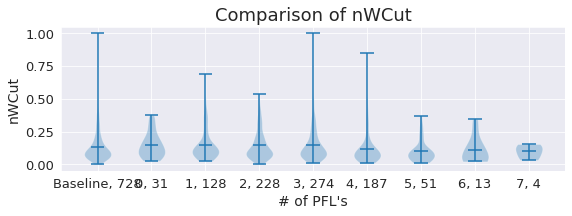

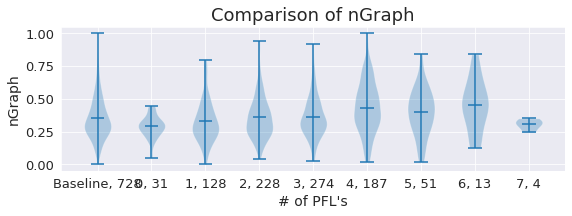

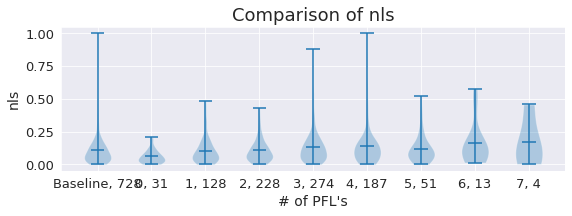

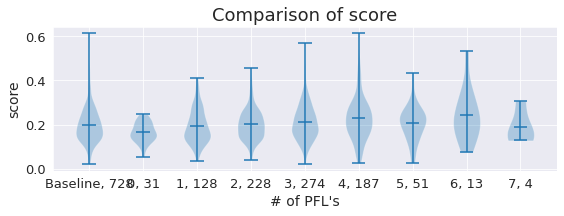

In [17]:
get_info_for = ['nWCut', 'nGraph', 'nls', 'score']

for key in get_info_for:
    data = []
    data0 = [results[r][key] for r in results if results[r]['Baseline'] == True]
    label = ['Baseline, ' + str(len(data0))]
    data.append(data0)
    for i in range(10):
        data1 = [results[r][key] for r in results if results[r]['PFL'] == i]
        if data1 != []:
            data.append(data1)
            label.append(str(i) + ', ' + str(len(data1)))
    fig = plt.figure(figsize =(7, 2))
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.violinplot(data, showmeans=True)
    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], label)
    ax.set_title('Comparison of ' + key)
    ax.set_xlabel('# of PFL\'s')
    ax.set_ylabel(key)
    plt.show()

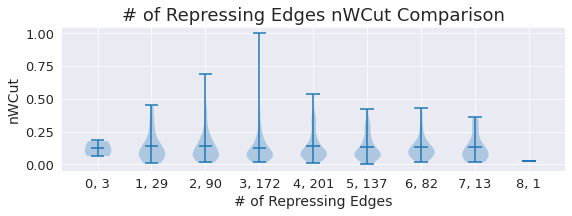

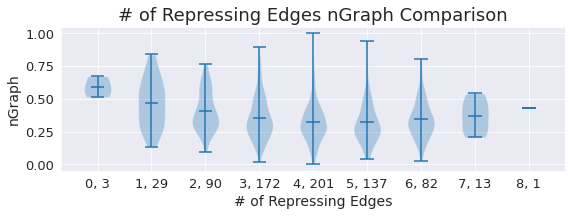

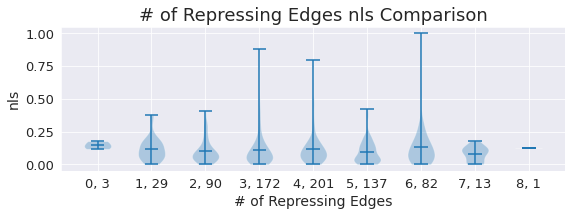

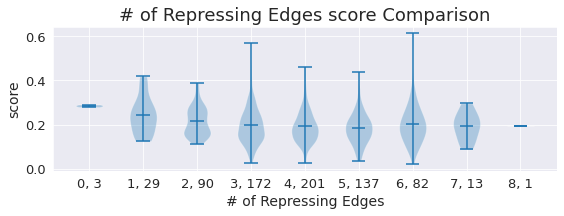

In [18]:
get_info_for = ['nWCut', 'nGraph', 'nls', 'score']

for key in get_info_for:
    data = []
    label = []
    for i in [8, 7, 6, 5, 4, 3, 2, 1, 0]:
        data1 = [results[r][key] for r in results if results[r]['RE'] == i and results[r]['Baseline'] == True]
        if data1 != []:
            data.append(data1)
            label.append(str(8-i) + ', ' + str(len(data1)))
    fig = plt.figure(figsize =(7, 2))
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.violinplot(data, showmeans=True)
    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], label)
    ax.set_title('# of Repressing Edges '+key+' Comparison')
    ax.set_xlabel('# of Repressing Edges')
    ax.set_ylabel(key)
    plt.show()

nWCut & coef & std dev & t-value & p-value & 95\% ci
intercept & 0.154 & 0.022 & 7.1 & 0.0 & [0.112, 0.197]
ACDC3 & -0.009 & 0.017 & -0.542 & 0.588 & [-0.042, 0.024]
ACDC2 & 0.05 & 0.019 & 2.643 & 0.008 & [0.013, 0.087]
ACDC1 & -0.011 & 0.017 & -0.69 & 0.49 & [-0.044, 0.021]
Ultra Strong & -0.012 & 0.014 & -0.915 & 0.36 & [-0.039, 0.014]
Strict Verd & 0.092 & 0.026 & 3.508 & 0.0 & [0.041, 0.144]
Reinitz & 0.03 & 0.029 & 1.018 & 0.309 & [-0.028, 0.087]
NFL & 0.001 & 0.003 & 0.207 & 0.836 & [-0.006, 0.007]
PFL & -0.009 & 0.003 & -2.59 & 0.01 & [-0.016, -0.002]
RE & 0.0 & 0.003 & 0.161 & 0.872 & [-0.005, 0.006]


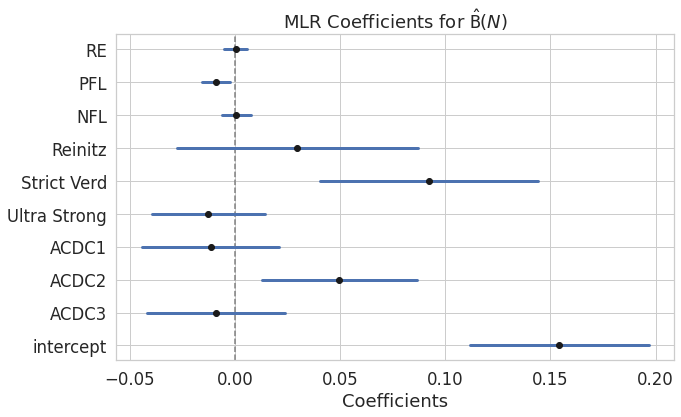

nGraph & coef & std dev & t-value & p-value & 95\% ci
intercept & 0.436 & 0.03 & 14.511 & 0.0 & [0.377, 0.495]
ACDC3 & -0.047 & 0.023 & -2.024 & 0.043 & [-0.092, -0.001]
ACDC2 & 0.21 & 0.026 & 8.096 & 0.0 & [0.159, 0.261]
ACDC1 & 0.031 & 0.023 & 1.331 & 0.184 & [-0.015, 0.076]
Ultra Strong & -0.013 & 0.019 & -0.684 & 0.494 & [-0.05, 0.024]
Strict Verd & 0.098 & 0.036 & 2.701 & 0.007 & [0.027, 0.17]
Reinitz & 0.153 & 0.04 & 3.782 & 0.0 & [0.074, 0.232]
NFL & -0.045 & 0.005 & -9.461 & 0.0 & [-0.054, -0.036]
PFL & -0.005 & 0.005 & -1.054 & 0.292 & [-0.014, 0.004]
RE & 0.014 & 0.004 & 3.606 & 0.0 & [0.006, 0.022]


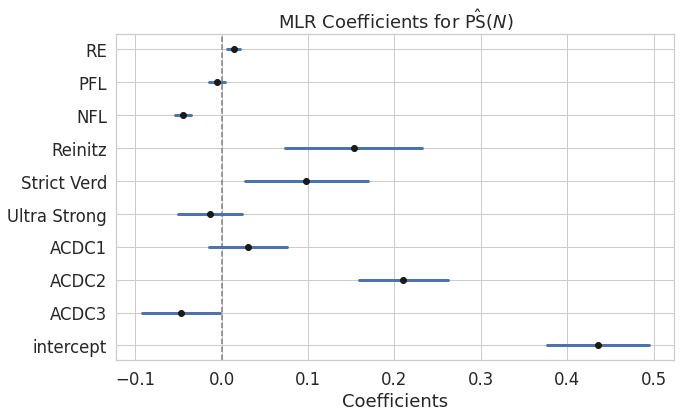

nls & coef & std dev & t-value & p-value & 95\% ci
intercept & 0.078 & 0.022 & 3.572 & 0.0 & [0.035, 0.121]
ACDC3 & 0.039 & 0.017 & 2.311 & 0.021 & [0.006, 0.072]
ACDC2 & 0.037 & 0.019 & 1.928 & 0.054 & [-0.001, 0.074]
ACDC1 & 0.033 & 0.017 & 1.951 & 0.051 & [-0.0, 0.066]
Ultra Strong & 0.042 & 0.014 & 3.071 & 0.002 & [0.015, 0.069]
Strict Verd & -0.025 & 0.027 & -0.959 & 0.338 & [-0.077, 0.027]
Reinitz & 0.036 & 0.029 & 1.234 & 0.217 & [-0.021, 0.094]
NFL & 0.002 & 0.003 & 0.526 & 0.599 & [-0.005, 0.009]
PFL & 0.01 & 0.003 & 2.996 & 0.003 & [0.004, 0.017]
RE & -0.0 & 0.003 & -0.127 & 0.899 & [-0.006, 0.005]


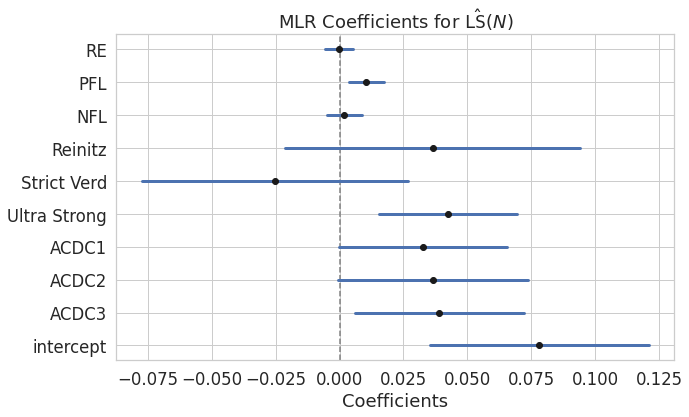

score & coef & std dev & t-value & p-value & 95\% ci
intercept & 0.223 & 0.015 & 14.616 & 0.0 & [0.193, 0.253]
ACDC3 & -0.006 & 0.012 & -0.481 & 0.631 & [-0.029, 0.017]
ACDC2 & 0.099 & 0.013 & 7.497 & 0.0 & [0.073, 0.125]
ACDC1 & 0.017 & 0.012 & 1.48 & 0.139 & [-0.006, 0.04]
Ultra Strong & 0.006 & 0.01 & 0.586 & 0.558 & [-0.013, 0.024]
Strict Verd & 0.055 & 0.018 & 2.982 & 0.003 & [0.019, 0.091]
Reinitz & 0.073 & 0.021 & 3.559 & 0.0 & [0.033, 0.113]
NFL & -0.014 & 0.002 & -5.864 & 0.0 & [-0.019, -0.009]
PFL & -0.001 & 0.002 & -0.489 & 0.625 & [-0.006, 0.004]
RE & 0.005 & 0.002 & 2.384 & 0.017 & [0.001, 0.009]


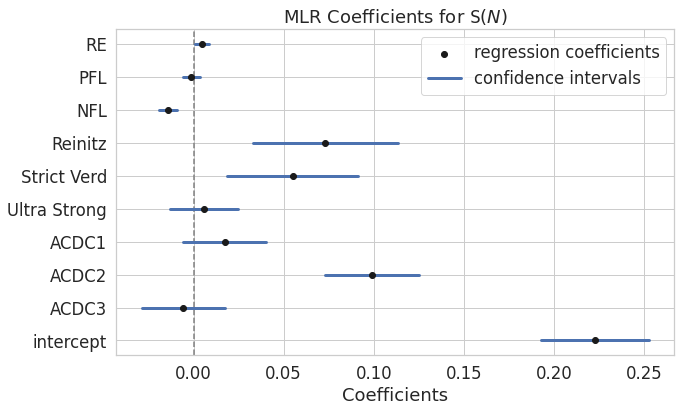

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# Multi Linear Regression
 
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
alpha = 0.05 # 95% confidence interval
keys = ['ACDC3', 'ACDC2', 'ACDC1', 'Ultra Strong', 'Strict Verd', 'Reinitz', 'NFL', 'PFL', 'RE'] # DJ of interest
lab = ['intercept', *keys]
for m in ['nWCut', 'nGraph', 'nls', 'score']:
    x = []
    y1 = []
    labels = []
    for r in results:
    #if r != 2272:
            #if r != 25338:
            #if results[r]['bl2'] == False:
                labels.append(r)
                s = [int(results[r][key]) for key in keys]
                x.append(s)
                y1.append(results[r][m])
    X, Y = np.array(x), np.array(y1)
    model = LinearRegression().fit(X, Y)
    lr = sm.OLS(y1, sm.add_constant(X)).fit()
    conf_interval = lr.conf_int(alpha)

    r_sq = model.score(X, Y)
    data = [(model.intercept_, conf_interval[0][0], conf_interval[0][1], 0)]
    b = model.coef_
    coef = [model.intercept_, *b]
    print(f'{m} & coef & std dev & t-value & p-value & 95\% ci')
    for i in range(10):
        print(f'{lab[i]} & {round(coef[i],3)} & {round(lr.bse[i],3)} & {round(lr.tvalues[i],3)} & {round(lr.pvalues[i],3)} & [{round(conf_interval[i][0],3)}, {round(conf_interval[i][1],3)}]')

    for i in range(len(keys)):
        #print(f'when {keys[i]} is true,  we are 95% confident that the scores true mean changes by between {round(conf_interval[i+1][0],3)} and {round(conf_interval[i+1][1],3)}')
        data.append((b[i], conf_interval[i+1][0], conf_interval[i+1][1],i+1))


    figure(figsize=(10, 6))
    plt.axvline(x = 0, color = 'gray', linestyle = 'dashed')
    for x,lower,upper,y in data:
        if data[-1] == (x,lower,upper,y):
            plt.scatter(x,y,color='k', label = 'regression coefficients', zorder=10)
            plt.plot((lower,upper),(y,y),'b-', label = 'confidence intervals', zorder=5, linewidth = 3)
        else:
            plt.scatter(x,y,color='k', zorder=10)
            plt.plot((lower,upper),(y,y),'b-', zorder=5, linewidth = 3)
            
    plt.title(f'MLR Coefficients for {key_lab[m]}')
    plt.xlabel('Coefficients')
    a = plt.yticks(list(range(len(lab))), lab)
    if m == 'score':
        plt.legend()
    plt.show()


/home/elizabeth/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/elizabeth/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


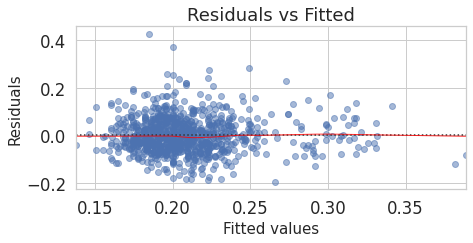

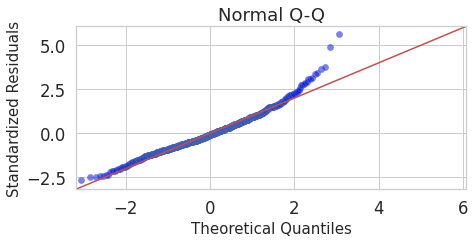

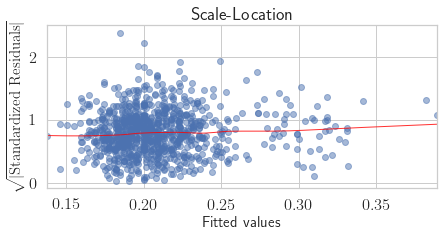

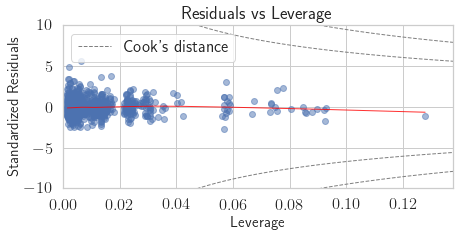

In [20]:
diagnostic_plots(X, y1, keys, fs = (7,3), labels = lab, model_fit=None)

In [21]:
avg_lev = len(keys)/len(y1) # average leverage
high_lev = 2*avg_lev # high leverage
avg_lev, high_lev

(0.009825327510917031, 0.019650655021834062)

In [22]:
data = []
for r in results:
    row = []
    for key in keys:
        row.append(int(results[r][key]))
    data.append(row)
df = pd.DataFrame(data, columns = keys)

In [23]:
# compute the vif for all given features, vif >= 5 is an issue  

considered_features = keys
compute_vif(df, considered_features)

,Variable,VIF
0,ACDC3,1.073984
1,ACDC2,1.049808
2,ACDC1,1.104556
3,Ultra Strong,1.182097
4,Strict Verd,1.048549
5,Reinitz,1.085719
6,NFL,1.615108
7,PFL,1.566431
8,RE,1.417122


In [24]:
# Paper Results Table 3 
keys = ['ACDC1', 'ACDC2', 'ACDC3', 'Ultra Strong', 'Strict Verd', 'Reinitz']
print('Feature & Total &&& Disjoint &&& Sampled &&& Scored &&& Sampled &&& Scored &&& Total Scored')
for k in keys:
    c = 0
    tot_aval = 0
    tot_feat = 0
    tot_disj = 0
    tot_bl_consid = 0
    tot_nbl_consid = 0
    tot_bl_scored = 0
    tot_nbl_scored = 0
    for r in all_pos:
        if all_pos[r][k] == True:
            tot_aval +=1
            if all_pos[r]['Baseline'] == True:
                tot_bl_consid += 1
            if all_pos[r]['Feature'] == True:
                tot_feat += 1
            if all_pos[r]['Non Baseline'] == True:
                tot_nbl_consid += 1
            if int(r) in results:
                if results[int(r)]['Baseline'] == True:
                    tot_bl_scored += 1
                if results[int(r)]['Non Baseline'] == True:
                    tot_nbl_scored += 1
            disjoint = True
            for k1 in keys:
                if k!=k1:
                    if all_pos[r][k1] == True:
                        disjoint = False
            if disjoint == True:
                tot_disj += 1

    print(k, f'& {tot_aval} &&& {tot_disj} &&& {tot_bl_consid} &&& {tot_bl_scored} &&& {tot_nbl_consid} &&& {tot_nbl_scored} &&& {tot_bl_scored+tot_nbl_scored}')

keys = ['RE', 'PFL', 'NFL'] 
print(f'Count of Number Feature & RE && PFL && NFL && RE & PFL & NFL & RE & PFL & NFL & RE & PFL & NFL & RE & PFL & NFL & RE & PFL & NFL')
print(f' & $\mathcal N$ & $\mathcal F$ & $\mathcal N$ & $\mathcal F$ & $\mathcal N$ & $\mathcal F$')
for i in range(9):
    a = []
    b = []
    c = []
    d = []
    e = []
    f = []
    for k in keys:
        tot_aval = 0
        tot_feat = 0
        tot_bl_consid = 0
        tot_nbl_consid = 0
        tot_bl_scored = 0
        tot_nbl_scored = 0
        for r in all_pos:
            if all_pos[r][k] == i:
                tot_aval +=1
                #if all_pos[r]['Done'] == True:
                if all_pos[r]['Baseline'] == True:
                    tot_bl_consid += 1
                    if int(r) in results:
                        tot_bl_scored += 1
                if all_pos[r]['Feature'] == True:
                    tot_feat += 1
                if all_pos[r]['Non Baseline'] == True:
                    tot_nbl_consid += 1
                    if int(r) in results:
                        tot_nbl_scored += 1
                disjoint = True
                for k1 in keys:
                    if k!=k1:
                        if all_pos[r][k1] == True:
                            disjoint = False
                if disjoint == True:
                    tot_disj += 1
        a.append((tot_aval, tot_feat))
        b.append(tot_bl_consid)
        c.append(tot_bl_scored)
        d.append(tot_nbl_consid)
        e.append(tot_nbl_scored)
        f.append(tot_bl_scored + tot_nbl_scored)
        
    print(i,  f'& {a[0][0]} & {a[0][1]} & {a[1][0]} & {a[1][1]} & {a[2][0]} & {a[2][1]}& {b[0]} & {b[1]} & {b[2]} & {c[0]} & {c[1]} & {c[2]} & {d[0]} & {d[1]} & {d[2]} & {e[0]} & {e[1]} & {e[2]} & {f[0]} & {f[1]} & {f[2]}')
a = [r for r in all_pos if all_pos[r]['Baseline'] == True]
b = [r for r in results if results[r]['Baseline'] == True]
c = [r for r in all_pos if all_pos[r]['Non Baseline'] == True]
d = [r for r in results if results[r]['Non Baseline'] == True]
e = [r for r in results if results[r]['Baseline'] == True or results[r]['Non Baseline'] == True]
print(f'Total & {len(all_pos)} &&&&&& {len(a)} &&& {len(b)} &&& {len(c)} &&& {len(d)} &&& {len(e)}')

Feature & Total &&& Disjoint &&& Sampled &&& Scored &&& Sampled &&& Scored &&& Total Scored
ACDC1 & 468 &&& 387 &&& 7 &&& 7 &&& 44 &&& 43 &&& 50
ACDC2 & 468 &&& 411 &&& 3 &&& 3 &&& 34 &&& 32 &&& 35
ACDC3 & 468 &&& 387 &&& 9 &&& 7 &&& 41 &&& 40 &&& 47
Ultra Strong & 704 &&& 583 &&& 10 &&& 10 &&& 75 &&& 72 &&& 82
Strict Verd & 170 &&& 116 &&& 0 &&& 0 &&& 18 &&& 17 &&& 17
Reinitz & 85 &&& 37 &&& 1 &&& 1 &&& 14 &&& 13 &&& 14
Count of Number Feature & RE && PFL && NFL && RE & PFL & NFL & RE & PFL & NFL & RE & PFL & NFL & RE & PFL & NFL & RE & PFL & NFL
 & $\mathcal N$ & $\mathcal F$ & $\mathcal N$ & $\mathcal F$ & $\mathcal N$ & $\mathcal F$
0 & 255 & 0 & 1680 & 0 & 2160 & 120& 1 & 31 & 33 & 1 & 31 & 33 & 0 & 0 & 17 & 0 & 0 & 16 & 1 & 31 & 49
1 & 1824 & 0 & 7680 & 128 & 5952 & 217& 13 & 119 & 82 & 13 & 113 & 81 & 0 & 17 & 21 & 0 & 16 & 20 & 13 & 129 & 101
2 & 6060 & 0 & 14256 & 488 & 15888 & 752& 83 & 191 & 184 & 82 & 188 & 175 & 0 & 43 & 69 & 0 & 41 & 66 & 82 & 229 & 241
3 & 12120 & 0 & 17

In [25]:
# Appendix D Network topolgy latex tikz figure output
# 18176: 'FullConn',  46402: 'StrongEdges'
interest = [25338,2888,18176,46402,6420,9391,21283]
name = ['network 25338','network 2888', 'FullConn', 'StrongEdges','network 6420', 'network 9391', 'network 21283']
interest_color = {}
interest_marker = {}
interest_name = {}
count = 0
pallet = ['darkorange', 'red', 'blue', 'green', 'black', 'fuchsia', 'darkorchid', 'yellowgreen', 'pink' ]
marker = ['s','o', 'p', 'X',  '^', 'D', 'P', 'v', 'o' ]
for i in interest:
    interest_name[i] = name[count]
    interest_color[i] = pallet[count]
    interest_marker[i] = marker[count]
    count += 1
    
def get_number_neg_out_edges_from_string(string):
    return len(re.findall('~', string, flags=re.MULTILINE))

top = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[]}
interest_top = {}
key = 'score'
for r in interest:
    if r != 21283:
        network = get_network_string(results[r]['edges'][0], results[r]['edges'][1])
        interest_top[r] = network
interest_top

network = get_network_string(all_pos['21283']['edges'][0], all_pos['21283']['edges'][1])
interest_top[21283] = network

import re
ultra_strong_motif = [(('Hb', 'Kni'), 0),(('Kni', 'Hb'), 0),(('Gt', 'Kr'), 0),(('Kr', 'Gt'), 0)]
ultra_strong_GtKr = [(('Gt', 'Kr'), 0),(('Kr', 'Gt'), 0)]
ultra_strong_HbKni = [(('Hb', 'Kni'), 0),(('Kni', 'Hb'), 0)]
ACDC1_motif = [(('Gt', 'Kr'), 0),(('Kr', 'Gt'), 0),(('Hb', 'Gt'), 0),(('Kr', 'Hb'), 0)]
ACDC2_motif = [(('Hb', 'Kni'), 0),(('Kni', 'Hb'), 0), (('Kni', 'Kr'), 0), (('Kr', 'Hb'), 0)]
ACDC3_motif = [(('Gt', 'Kr'), 0),(('Kr', 'Gt'), 0),(('Kni', 'Kr'), 0), (('Gt', 'Kni'), 0)]
best_scoring_edges = [(('Gt', 'Hb'), 1), (('Kni', 'Kr'), 0), (('Kr', 'Kni'), 0), (('Hb', 'Kni'), 0)]

Reinitz = [[['Hb', 'Kr'], ['Kr','Hb'], ['Hb', 'Kni'], ['Kni', 'Hb'], ['Gt', 'Kr'], 
            ['Kr', 'Gt'], ['Gt', 'Kni'], ['Hb', 'Gt'], ['Gt', 'Hb'], ['Kr', 'Kni'], ['Kni', 'Kr']], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] ]
Reinitz_string = get_network_string(Reinitz[0], Reinitz[1])

Perkins = [[['Hb', 'Kr'], ['Kr','Hb'], ['Hb', 'Kni'], ['Kni', 'Hb'], ['Gt', 'Kr'], 
            ['Kr', 'Gt'], ['Gt', 'Kni'], ['Hb', 'Gt'], ['Kni', 'Kr']], [0, 0, 0, 0, 0, 0, 0, 0, 0] ]
Perkins_string = get_network_string(Perkins[0], Perkins[1])

Verd = [[['Hb', 'Kr'], ['Kr','Hb'], ['Hb', 'Kni'], ['Kni', 'Hb'], ['Gt', 'Kr'], ['Kr', 'Gt'], 
         ['Gt', 'Kni'], ['Kni', 'Gt'], ['Hb', 'Gt'], ['Gt', 'Hb'], ['Kr', 'Kni'], ['Kni', 'Kr']], [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0] ]
Verd_string = get_network_string(Verd[0], Verd[1])

neq_edges = ['~Hb', '~Gt', '~Kr', '~Kni']
pos_edges = ['Hb', 'Gt', 'Kr', 'Kni']
color = {'Hb': 'yellow!80!black', 'Gt': 'myblue!80!white', 'Kr': 'mygreen!80!black', 'Kni': 'red!80!white'}
start_string = r'\begin{tikzpicture}[main node/.style={circle,fill=white!20,draw,font=\sffamily\normalsize\bfseries}]' + '\n' + r'\node[main node, fill=yellow] (Hb) at (1.5,1.5) {Hb};' + '\n'+r'\node[main node, fill=mygreen!80!black] (Kr) at (3,0) {Kr};'+ '\n' +r'\node[main node, fill=myblue!80!white] (Gt) at (0, 0) {Gt};'+ '\n' +r'\node[main node, fill=red!80!white] (Kni) at (1.5,-1.5) {Kni};'+ '\n' 
end_string = ';\n \end{tikzpicture}\quad'
for i in interest:
    print(start_string)
    print(r'\node (A) at (1.5, 2.25) {' + interest_name[i] + '};\n')
    print(r'\path[->,>=angle 90,ultra thick]')
    s= interest_top[i]
    #print(s)
    Hb = re.search('Hb :', s).span()
    Gt = re.search('Gt :', s).span()
    Kr = re.search('Kr :', s).span()
    Kni = re.search('Kni :', s).span()
    iter = [('(Hb)', s[Hb[1]:Gt[0]]), ('(Gt)', s[Gt[1]:Kr[0]]), ('(Kr)',s[Kr[1]:Kni[0]]), ('(Kni)',s[Kni[1]:])]
    for i in iter:
        for ne in neq_edges:
            if ne in i[1]:
                print('('+ ne[1:] + ') edge[-|, bend left, shorten >= 3pt, ' + color[ne[1:]] + '] ' + i[0] )
            else:
                if ne[1:] in i[1]:
                    print('('+ ne[1:] + ') edge[->, bend left, shorten >= 3pt, ' + color[ne[1:]] + '] ' + i[0] )
    print(end_string)
#21283
main_net = [('Reinitz', Reinitz_string), ('Verd', Verd_string)]

for i in main_net:
    print(start_string)
    print(r'\node (A) at (1.5, 2.25) {' + i[0] + '};\n')
    print(r'\path[->,>=angle 90,ultra thick]')
    s= i[1]
    #print(s)
    Hb = re.search('Hb :', s).span()
    Gt = re.search('Gt :', s).span()
    Kr = re.search('Kr :', s).span()
    Kni = re.search('Kni :', s).span()
    iter = [('(Hb)', s[Hb[1]:Gt[0]]), ('(Gt)', s[Gt[1]:Kr[0]]), ('(Kr)',s[Kr[1]:Kni[0]]), ('(Kni)',s[Kni[1]:])]
    for i in iter:
        for ne in neq_edges:
            if ne in i[1]:
                print('('+ ne[1:] + ') edge[-|, bend left, shorten >= 3pt, ' + color[ne[1:]] + '] ' + i[0] )
            else:
                if ne[1:] in i[1]:
                    print('('+ ne[1:] + ') edge[->, bend left, shorten >= 3pt, ' + color[ne[1:]] + '] ' + i[0] )
    print(end_string)

ACDC = [('ACDC1', ACDC1_motif), ('ACDC2', ACDC2_motif), ('ACDC3', ACDC3_motif)]
for i in ACDC:
    print(start_string)
    print(r'\node (A) at (1.5, 2.25) {' + i[0] + '};\n')
    print(r'\path[->,>=angle 90,ultra thick]')
    for e in i[1]:
        if e[1] == 0:
            print('('+ e[0][0] + ') edge[-|, bend left, shorten >= 3pt, ' + color[e[0][0]] + '] (' + e[0][1] + ')' )
        else:
            print('('+ e[0][0] + ') edge[->, bend left, shorten >= 3pt, ' + color[e[0][0]] + '] (' + e[0][1] + ')' )
    print(end_string)



\begin{tikzpicture}[main node/.style={circle,fill=white!20,draw,font=\sffamily\normalsize\bfseries}]
\node[main node, fill=yellow] (Hb) at (1.5,1.5) {Hb};
\node[main node, fill=mygreen!80!black] (Kr) at (3,0) {Kr};
\node[main node, fill=myblue!80!white] (Gt) at (0, 0) {Gt};
\node[main node, fill=red!80!white] (Kni) at (1.5,-1.5) {Kni};

\node (A) at (1.5, 2.25) {network 25338};

\path[->,>=angle 90,ultra thick]
(Kr) edge[->, bend left, shorten >= 3pt, mygreen!80!black] (Hb)
(Kni) edge[->, bend left, shorten >= 3pt, red!80!white] (Hb)
(Hb) edge[->, bend left, shorten >= 3pt, yellow!80!black] (Gt)
(Kr) edge[-|, bend left, shorten >= 3pt, mygreen!80!black] (Gt)
(Hb) edge[->, bend left, shorten >= 3pt, yellow!80!black] (Kr)
(Kni) edge[-|, bend left, shorten >= 3pt, red!80!white] (Kr)
(Hb) edge[->, bend left, shorten >= 3pt, yellow!80!black] (Kni)
(Gt) edge[->, bend left, shorten >= 3pt, myblue!80!white] (Kni)
;
 \end{tikzpicture}\quad
\begin{tikzpicture}[main node/.style={circle,fill=white